In [ ]:
#!pip3 install -q mediapipe
#!pip3 install -q imageio
#!pip3 install -q sklearn
#!pip3 install -q torch

You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


In [3]:
import cv2
import mediapipe as mp
import os
import numpy as np
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# warning levels 
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
# "0" = all logs (default)
# "1" = filter out INFO
# "2" = filter out INFO + WARNING
# "3" = filter out INFO + WARNING + ERROR 

In [4]:
data_folder = '../data/videos/'
signs = ['hello', 'bye', 'world']

MODEL_PATH = "hand_landmarker.task"  

## Extract Keypoints

In [ ]:
def extract_keypoints_for_signs(data_folder, signs, output_base):
    mp_holistic = mp.solutions.holistic

    # Número esperado de keypoints
    POSE_LANDMARKS = 33
    HAND_LANDMARKS = 21
    TOTAL_KEYPOINTS = POSE_LANDMARKS + 2 * HAND_LANDMARKS  # Cuerpo + 2 manos

    # Crear la carpeta base de salida
    os.makedirs(output_base, exist_ok=True)

    for sign in signs:
        video_folder = os.path.join(data_folder, sign)
        output_folder = os.path.join(output_base, sign)
        os.makedirs(output_folder, exist_ok=True)

        video_files = [f for f in os.listdir(video_folder) if f.endswith(('.mp4', '.avi', '.mov'))]
        if not video_files:
            print(f"⚠️ No se encontraron videos para el signo '{sign}' en {video_folder}")
            continue

        print(f" 🍓 Signo '{sign}': {len(video_files)} videos encontrados. Procesando...")

        for video_name in video_files:
            video_path = os.path.join(video_folder, video_name)
            cap = cv2.VideoCapture(video_path)

            if not cap.isOpened():
                print(f"⚠️ No se pudo abrir el video: {video_name}")
                continue

            keypoints_list = []
            print(f" 🥭 Procesando: {video_name}")

            with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                while cap.isOpened():
                    ret, frame = cap.read()
                    if not ret:
                        break

                    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    results = holistic.process(frame_rgb)
                    keypoints = [(0, 0, 0)] * TOTAL_KEYPOINTS

                    if results.pose_landmarks:
                        for i, lm in enumerate(results.pose_landmarks.landmark):
                            keypoints[i] = (lm.x, lm.y, lm.z)

                    if results.left_hand_landmarks:
                        for i, lm in enumerate(results.left_hand_landmarks.landmark):
                            keypoints[POSE_LANDMARKS + i] = (lm.x, lm.y, lm.z)

                    if results.right_hand_landmarks:
                        for i, lm in enumerate(results.right_hand_landmarks.landmark):
                            keypoints[POSE_LANDMARKS + HAND_LANDMARKS + i] = (lm.x, lm.y, lm.z)

                    keypoints_list.append(keypoints)

                cap.release()

            if keypoints_list:
                keypoints_array = np.array(keypoints_list)
                output_path = os.path.join(output_folder, video_name.replace(".mp4", ".npy"))
                np.save(output_path, keypoints_array)
                print(f"✅ Keypoints guardados en {output_path}")
            else:
                print(f"⚠️ No se extrajeron keypoints para {video_name}")

    print("\n🎉 Proceso finalizado.")


In [ ]:
output_main_folder = '../data/keypoints'
extract_keypoints_for_signs('../data/videos/', ['hello', 'bye', 'world'], output_main_folder)

🥭 Signo 'hello': 9 videos encontrados. Procesando...
Procesando: Tyler-session-ASL_2008_05_29a-scene-49-700-717-camera1.mp4


I0000 00:00:1745567717.517201  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1745567717.574437  848347 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567717.582475  848347 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567717.585477  848350 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567717.585534  848354 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567717.585556  848347 inference_feedback_manager.cc:114] Feedback manager requires a

✅ Keypoints guardados en ../data/keypoints/hello/Tyler-session-ASL_2008_05_29a-scene-49-700-717-camera1.npy
Procesando: Naomi-session-ASL_2008_08_13-scene-10-1822-1842-camera1.mp4


I0000 00:00:1745567718.016108  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567718.067236  848390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567718.075349  848390 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567718.076328  848393 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567718.076446  848396 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567718.076788  848388 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/Naomi-session-ASL_2008_08_13-scene-10-1822-1842-camera1.npy
Procesando: Dana-session-ASL_2007_05_24-scene-17-2369-2402-camera1.mp4


I0000 00:00:1745567718.581075  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567718.630952  848416 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567718.638993  848426 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567718.639990  848419 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567718.639992  848422 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567718.640268  848421 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/Dana-session-ASL_2007_05_24-scene-17-2369-2402-camera1.npy
Procesando: Brady-session-ASL_2011_06_14_Brady-scene-33-3755-3769-camera1.mp4


I0000 00:00:1745567719.436521  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567719.488949  848449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567719.496898  848448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567719.498025  848449 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567719.498079  848448 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567719.498082  848450 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/Brady-session-ASL_2011_06_14_Brady-scene-33-3755-3769-camera1.npy
Procesando: Lana-session-ASL_2006_10_10-scene-14-2040-2050-camera1.mp4


I0000 00:00:1745567719.876800  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567719.931035  848490 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567719.938364  848495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567719.939368  848491 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567719.939385  848495 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567719.939774  848492 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/Lana-session-ASL_2006_10_10-scene-14-2040-2050-camera1.npy
Procesando: Liz-session-ASL_2008_02_01-scene-21-1160-1182-camera1.mp4


I0000 00:00:1745567720.216280  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567720.266586  848517 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567720.273751  848517 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567720.274683  848522 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567720.274698  848524 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567720.274732  848527 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/Liz-session-ASL_2008_02_01-scene-21-1160-1182-camera1.npy
Procesando: Liz-session-ASL_2008_02_01-scene-12-835-880-camera1.mp4


I0000 00:00:1745567720.844993  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567720.899087  848544 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567720.906605  848550 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567720.907485  848543 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567720.907571  848542 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567720.907572  848553 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/Liz-session-ASL_2008_02_01-scene-12-835-880-camera1.npy
Procesando: Brady-session-ASL_2011_06_14_Brady-scene-29-1865-1885-camera1.mp4


I0000 00:00:1745567721.983221  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567722.032516  848584 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567722.040133  848591 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567722.041087  848595 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567722.041131  848589 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567722.041139  848585 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/Brady-session-ASL_2011_06_14_Brady-scene-29-1865-1885-camera1.npy
Procesando: Naomi-session-ASL_2008_08_13-scene-17-1186-1205-camera1.mp4


I0000 00:00:1745567722.556428  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567722.609757  848659 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567722.618289  848666 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567722.619213  848659 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567722.619291  848669 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567722.620209  848660 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/hello/Naomi-session-ASL_2008_08_13-scene-17-1186-1205-camera1.npy
🥭 Signo 'bye': 9 videos encontrados. Procesando...
Procesando: Brady-session-ASL_2011_07_22_Brady-scene-25-2180-2221-camera1.mp4


I0000 00:00:1745567723.112918  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567723.167989  848689 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567723.175603  848691 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567723.176662  848690 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567723.176670  848691 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567723.177542  848692 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Brady-session-ASL_2011_07_22_Brady-scene-25-2180-2221-camera1.npy
Procesando: Screen Recording 2025-03-17 at 19.43.55.mov


I0000 00:00:1745567724.156871  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567724.211915  848723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567724.219288  848723 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567724.220279  848727 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567724.220318  848722 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567724.220899  848729 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Screen Recording 2025-03-17 at 19.43.55.mov
Procesando: Screen Recording 2025-03-17 at 19.44.25.mov


I0000 00:00:1745567727.308508  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567727.362971  848789 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567727.371513  848787 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567727.372361  848797 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567727.372454  848794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567727.372560  848790 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Screen Recording 2025-03-17 at 19.44.25.mov
Procesando: Screen Recording 2025-03-17 at 19.42.41.mov


I0000 00:00:1745567730.308597  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567730.363805  848959 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567730.372775  848961 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567730.373777  848957 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567730.373864  848965 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567730.373880  848967 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Screen Recording 2025-03-17 at 19.42.41.mov
Procesando: Screen Recording 2025-03-17 at 19.45.38.mov


I0000 00:00:1745567733.537657  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567733.594156  849001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567733.603138  849001 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567733.604064  849010 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567733.604159  849005 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567733.604182  849002 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Screen Recording 2025-03-17 at 19.45.38.mov
Procesando: Liz-session-ASL_2008_03_28-scene-37-1435-1485-camera1.mp4


I0000 00:00:1745567736.893340  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567736.947253  849040 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567736.954593  849040 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567736.955714  849042 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567736.955754  849041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567736.955756  849049 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Liz-session-ASL_2008_03_28-scene-37-1435-1485-camera1.npy
Procesando: Screen Recording 2025-03-17 at 19.44.52.mov


I0000 00:00:1745567738.167723  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567738.223441  849078 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567738.230870  849077 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567738.231896  849084 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567738.232522  849080 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567738.232609  849085 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Screen Recording 2025-03-17 at 19.44.52.mov
Procesando: Screen Recording 2025-03-17 at 19.45.17.mov


I0000 00:00:1745567741.517675  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567741.568832  849191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567741.576941  849194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567741.577872  849190 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567741.577911  849195 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567741.577928  849200 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Screen Recording 2025-03-17 at 19.45.17.mov
Procesando: Brady-session-ASL_2011_07_22_Brady-scene-57-2394-2426-camera1.mp4


I0000 00:00:1745567745.324943  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567745.375835  849269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567745.383283  849269 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567745.384353  849277 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567745.384397  849278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567745.384805  849268 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/bye/Brady-session-ASL_2011_07_22_Brady-scene-57-2394-2426-camera1.npy
🥭 Signo 'world': 9 videos encontrados. Procesando...
Procesando: Screen Recording 2025-03-17 at 19.51.51.mov


I0000 00:00:1745567746.197413  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567746.254542  849348 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567746.261941  849348 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567746.262867  849352 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567746.262874  849356 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567746.262925  849358 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Screen Recording 2025-03-17 at 19.51.51.mov
Procesando: Screen Recording 2025-03-17 at 19.52.17.mov


I0000 00:00:1745567749.567865  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567749.624011  849425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567749.631749  849425 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567749.632679  849431 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567749.632758  849428 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567749.632836  849430 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Screen Recording 2025-03-17 at 19.52.17.mov
Procesando: Screen Recording 2025-03-17 at 19.52.38.mov


I0000 00:00:1745567752.641804  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567752.694266  849475 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567752.701886  849474 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567752.702969  849474 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567752.702991  849480 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567752.703597  849484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Screen Recording 2025-03-17 at 19.52.38.mov
Procesando: Screen Recording 2025-03-17 at 19.50.29.mov


I0000 00:00:1745567757.953706  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567758.008563  849583 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567758.018745  849583 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567758.019846  849583 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567758.019860  849590 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567758.020322  849585 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Screen Recording 2025-03-17 at 19.50.29.mov
Procesando: Liz-session-ASL_2008_03_28-scene-44-2671-2727-camera1.mp4


I0000 00:00:1745567759.975228  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567760.031071  849617 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567760.039610  849626 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567760.040652  849617 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567760.040656  849618 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567760.040687  849619 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Liz-session-ASL_2008_03_28-scene-44-2671-2727-camera1.npy
Procesando: Screen Recording 2025-03-17 at 19.51.21.mov


I0000 00:00:1745567761.425576  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567761.478246  849652 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567761.486027  849652 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567761.486949  849656 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567761.486996  849658 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567761.487645  849651 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Screen Recording 2025-03-17 at 19.51.21.mov
Procesando: Screen Recording 2025-03-17 at 19.49.49.mov


I0000 00:00:1745567763.001605  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567763.057842  849703 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567763.066649  849701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567763.067578  849705 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567763.067578  849701 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567763.067599  849702 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Screen Recording 2025-03-17 at 19.49.49.mov
Procesando: Brady-session-ASL_2011_07_22_Brady-scene-33-597-631-camera1.mp4


I0000 00:00:1745567764.935514  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567764.992319  849742 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567764.999891  849750 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567765.000890  849742 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567765.000951  849741 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567765.000987  849751 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Brady-session-ASL_2011_07_22_Brady-scene-33-597-631-camera1.npy
Procesando: Screen Recording 2025-03-17 at 19.49.04.mov


I0000 00:00:1745567765.847781  848019 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1745567765.905196  849785 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567765.913331  849786 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567765.914244  849790 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567765.914263  849794 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1745567765.914334  849784 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling supp

✅ Keypoints guardados en ../data/keypoints/world/Screen Recording 2025-03-17 at 19.49.04.mov

🎉 Proceso finalizado.


## Generate train test data

In [14]:
SEQUENCE_LENGTH = 30  # Fixed number of frames

def load_dataset(signs, keypoints_root):
    sequences = []
    labels = []

    for sign in signs:
        sign_folder = os.path.join(keypoints_root, sign)
        if not os.path.exists(sign_folder):
            print(f"⚠️ Folder not found: {sign_folder}")
            continue

        for filename in os.listdir(sign_folder):
            if not filename.endswith(".npy"):
                continue

            file_path = os.path.join(sign_folder, filename)
            sequence = np.load(file_path)

            # Handle expected shape: (T, 75, 3)
            if len(sequence.shape) != 3 or sequence.shape[1:] != (75, 3):
                print(f"⚠️ Skipping {file_path}: unexpected shape {sequence.shape}")
                continue

            # Flatten per frame → (T, 225)
            sequence = sequence.reshape(sequence.shape[0], -1)

            # Pad or truncate to fixed length
            if sequence.shape[0] < SEQUENCE_LENGTH:
                pad_width = SEQUENCE_LENGTH - sequence.shape[0]
                sequence = np.pad(sequence, ((0, pad_width), (0, 0)), mode='constant')
            else:
                sequence = sequence[:SEQUENCE_LENGTH]

            sequences.append(sequence)
            labels.append(sign)

    if not sequences:
        raise ValueError("❌ No valid sequences were loaded. Please check your input files.")

    # Convert to numpy arrays
    X = np.array(sequences)  # shape: (num_samples, SEQUENCE_LENGTH, 225)
    y = np.array(labels)

    # Encode labels to integers
    encoder = LabelEncoder()
    y_encoded = encoder.fit_transform(y)

    # Normalize keypoints
    X_mean = X.mean(axis=(0, 1))
    X_std = X.std(axis=(0, 1)) + 1e-6
    X_normalized = (X - X_mean) / X_std

    # Train-validation split
    X_train, X_val, y_train, y_val = train_test_split(
        X_normalized, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
    )

    print(f"✅ Dataset ready! Train: {X_train.shape}, Val: {X_val.shape}")
    print(f"Classes: {encoder.classes_}")

    return X_train, X_val, y_train, y_val, encoder, X_mean, X_std


In [15]:
signs = ["hello", "bye", "world"]
keypoints_folder = "../data/keypoints"
X_train, X_val, y_train, y_val, label_encoder, X_mean, X_std = load_dataset(signs, keypoints_folder)

✅ Dataset ready! Train: (21, 30, 225), Val: (6, 30, 225)
Classes: ['bye' 'hello' 'world']


In [33]:
# guardamos label_encoder para implementarlo en la app 
with open("../app/label_encoder.pkl", "wb") as f:
    pickle.dump(label_encoder, f)

In [34]:
# guardamos keypoint normalization parameters para app 
scaler = {"mean": X_mean, "std": X_std}

with open("../app/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

In [18]:
from collections import Counter
print(Counter(y_train))


Counter({2: 7, 0: 7, 1: 7})


## modelo lstm en pytorch

In [ ]:
# Parámetros
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = len(label_encoder.classes_)
INPUT_SIZE = X_train.shape[2]
SEQUENCE_LENGTH = X_train.shape[1]

# Dataset y DataLoader
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# Modelo LSTM

class SignLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1, num_classes=NUM_CLASSES):
        super(SignLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # output: (batch, seq_len, hidden_size)
        # hn: (num_layers, batch, hidden_size)
        _, (hn, _) = self.lstm(x)
        out = self.fc(hn[-1])  # usamos la última capa
        return out


model = SignLSTM(INPUT_SIZE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [22]:
# entrenamiento del modelo

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()

    print(f"📚 Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss:.4f} | Val Accuracy: {100*correct/total:.2f}%")


📚 Epoch 1/30 | Loss: 1.0854 | Val Accuracy: 33.33%
📚 Epoch 2/30 | Loss: 0.8878 | Val Accuracy: 66.67%
📚 Epoch 3/30 | Loss: 0.7608 | Val Accuracy: 66.67%
📚 Epoch 4/30 | Loss: 0.6669 | Val Accuracy: 50.00%
📚 Epoch 5/30 | Loss: 0.5902 | Val Accuracy: 50.00%
📚 Epoch 6/30 | Loss: 0.5240 | Val Accuracy: 50.00%
📚 Epoch 7/30 | Loss: 0.4660 | Val Accuracy: 50.00%
📚 Epoch 8/30 | Loss: 0.4136 | Val Accuracy: 50.00%
📚 Epoch 9/30 | Loss: 0.3662 | Val Accuracy: 50.00%
📚 Epoch 10/30 | Loss: 0.3225 | Val Accuracy: 50.00%
📚 Epoch 11/30 | Loss: 0.2836 | Val Accuracy: 50.00%
📚 Epoch 12/30 | Loss: 0.2491 | Val Accuracy: 66.67%
📚 Epoch 13/30 | Loss: 0.2190 | Val Accuracy: 66.67%
📚 Epoch 14/30 | Loss: 0.1924 | Val Accuracy: 66.67%
📚 Epoch 15/30 | Loss: 0.1688 | Val Accuracy: 66.67%
📚 Epoch 16/30 | Loss: 0.1483 | Val Accuracy: 66.67%
📚 Epoch 17/30 | Loss: 0.1299 | Val Accuracy: 66.67%
📚 Epoch 18/30 | Loss: 0.1137 | Val Accuracy: 66.67%
📚 Epoch 19/30 | Loss: 0.0997 | Val Accuracy: 66.67%
📚 Epoch 20/30 | Loss:

In [28]:
# guardamos el modelo para implementarlo en la app 
torch.save(model.state_dict(), "../app/model.pth")

In [25]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = model(torch.tensor(X_train).float()).argmax(dim=1)
print(classification_report(y_train, y_pred))
print(confusion_matrix(y_train, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         7
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         7

    accuracy                           1.00        21
   macro avg       1.00      1.00      1.00        21
weighted avg       1.00      1.00      1.00        21

[[7 0 0]
 [0 7 0]
 [0 0 7]]


## Validación 

In [26]:
# Accuracy Score

from sklearn.metrics import accuracy_score

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in val_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        outputs = model(batch_x)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

acc = accuracy_score(all_labels, all_preds)
print(f"✅ Validation Accuracy: {acc * 100:.2f}%")

✅ Validation Accuracy: 100.00%


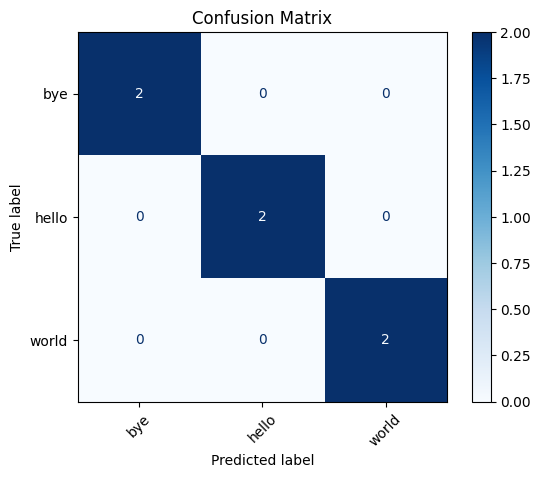

In [29]:
# confussion matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [30]:
# Precision, Recall, F1 Score

from sklearn.metrics import classification_report

print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_))


              precision    recall  f1-score   support

         bye       1.00      1.00      1.00         2
       hello       1.00      1.00      1.00         2
       world       1.00      1.00      1.00         2

    accuracy                           1.00         6
   macro avg       1.00      1.00      1.00         6
weighted avg       1.00      1.00      1.00         6



## Extract Start & End Frames Using Keypoints - NO USE

In [ ]:
# revisar estructura carpetas salida datos 

In [33]:
def extract_start_end_keypoints(data_folder, signs, output_base, frame_output_folder):
    mp_holistic = mp.solutions.holistic

    # n of keypoints
    POSE_LANDMARKS = 33
    HAND_LANDMARKS = 21
    TOTAL_KEYPOINTS = POSE_LANDMARKS + 2 * HAND_LANDMARKS  # Body + 2 hands

    for sign in signs: 
        video_folder = os.path.join(data_folder, sign)
        output_folder = os.path.join(output_base, sign)
        os.makedirs(output_folder, exist_ok=True)

        frame_output_folder = os.path.join(frame_output_folder, sign)
        os.makedirs(frame_output_folder, exist_ok=True)

        # Process video files
        video_files = [f for f in os.listdir(video_folder) if f.endswith(".mp4")]

        if not video_files:
            print("⚠️ No se encontraron archivos de video en la carpeta.")
        else:
            print(f"{len(video_files)} videos encontrados. Procesando...")

        # Function to calculate total movement between frames
        def calculate_movement(prev_kp, curr_kp):
            if prev_kp is None or curr_kp is None:
                return 0  # No movement detected if landmarks are missing

            total_movement = np.sum(np.linalg.norm(np.array(curr_kp) - np.array(prev_kp), axis=1))
            return total_movement

        # Process each video
        for video_name in video_files:
            video_path = os.path.join(video_folder, video_name)
            cap = cv2.VideoCapture(video_path)

            if not cap.isOpened():
                print(f"❌ No se pudo abrir el video: {video_name}")
                continue

            keypoints_list = []
            frame_list = []
            print(f"🍓 Procesando: {video_name}")

            with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                prev_keypoints = None
                start_index = None
                end_index = None
                movement_threshold = 5.0  # Adjust based on dataset (higher = less sensitive)

                frame_index = 0

                with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
                    prev_keypoints = None
                    start_index = None
                    end_index = None
                    movement_threshold = 5.0

                    frame_index = 0

                    while cap.isOpened():
                        ret, frame = cap.read()
                        if not ret:
                            break

                        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                        results = holistic.process(frame_rgb)

                        keypoints = np.zeros((TOTAL_KEYPOINTS, 3))

                        valid_detection = False  # Track if we detected anything at all

                        if results.pose_landmarks:
                            for i, lm in enumerate(results.pose_landmarks.landmark):
                                keypoints[i] = (lm.x, lm.y, lm.z)
                            valid_detection = True

                        if results.left_hand_landmarks:
                            for i, lm in enumerate(results.left_hand_landmarks.landmark):
                                keypoints[POSE_LANDMARKS + i] = (lm.x, lm.y, lm.z)
                            valid_detection = True

                        if results.right_hand_landmarks:
                            for i, lm in enumerate(results.right_hand_landmarks.landmark):
                                keypoints[POSE_LANDMARKS + HAND_LANDMARKS + i] = (lm.x, lm.y, lm.z)
                            valid_detection = True

                        keypoints_list.append(keypoints)
                        frame_list.append(frame)

                        if valid_detection:
                            # Use this as fallback start if nothing else is found
                            if start_index is None:
                                start_index = frame_index

                            # Always update last valid detection
                            end_index = frame_index

                            # Optional: enhance with movement detection
                            if prev_keypoints is not None:
                                movement = calculate_movement(prev_keypoints, keypoints)
                                if movement > movement_threshold and start_index is None:
                                    start_index = frame_index
                                if movement < movement_threshold:
                                    end_index = frame_index

                            prev_keypoints = keypoints

                        frame_index += 1

                cap.release()

            # ✅ Save keypoints
            if start_index is None or end_index is None:
                print(f"⚠️ No valid keypoints detected in: {video_name}")
                
            else:
                if keypoints_list:
                    keypoints_array = np.array(keypoints_list)
                    np.save(os.path.join(output_folder, video_name.replace(".mp4", ".npy")), keypoints_array)

                # ✅ Save start & end frames
                if start_index is not None:
                    start_frame_path = os.path.join(frame_output_folder, f"{video_name}_start.jpg")
                    cv2.imwrite(start_frame_path, frame_list[start_index])
                    print(f"✅ Start frame saved: {start_frame_path}")

                if end_index is not None:
                    end_frame_path = os.path.join(frame_output_folder, f"{video_name}_end.jpg")
                    cv2.imwrite(end_frame_path, frame_list[end_index])
                    print(f"✅ End frame saved: {end_frame_path}")

        print("🎉 Proceso finalizado.")

In [ ]:
output_folder = '../data/output_frames'
frame_output_folder = '../data/start_end_frames'

os.makedirs(output_folder, exist_ok=True)

extract_start_end_keypoints('../data/', ['hello', 'bye', 'world'], output_folder, frame_output_folder)

9 videos encontrados. Procesando...
🍓 Procesando: Tyler-session-ASL_2008_05_29a-scene-49-700-717-camera1.mp4


I0000 00:00:1742920504.000077 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920504.021052 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920504.062623 2172270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920504.072716 2172270 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920504.074465 2172272 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920504.074465 2172277 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920504.074536 2172278 in

✅ Start frame saved: ../data/start_end_frames/hello/Tyler-session-ASL_2008_05_29a-scene-49-700-717-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/Tyler-session-ASL_2008_05_29a-scene-49-700-717-camera1.mp4_end.jpg
🍓 Procesando: Naomi-session-ASL_2008_08_13-scene-10-1822-1842-camera1.mp4


I0000 00:00:1742920504.537537 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920504.552914 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920504.588717 2172317 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920504.598802 2172327 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920504.599715 2172322 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920504.599742 2172324 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920504.599819 2172318 in

✅ Start frame saved: ../data/start_end_frames/hello/Naomi-session-ASL_2008_08_13-scene-10-1822-1842-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/Naomi-session-ASL_2008_08_13-scene-10-1822-1842-camera1.mp4_end.jpg
🍓 Procesando: Dana-session-ASL_2007_05_24-scene-17-2369-2402-camera1.mp4


I0000 00:00:1742920505.137078 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920505.151790 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920505.191551 2172374 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920505.202778 2172373 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920505.203911 2172383 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920505.205015 2172382 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920505.205229 2172381 in

✅ Start frame saved: ../data/start_end_frames/hello/Dana-session-ASL_2007_05_24-scene-17-2369-2402-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/Dana-session-ASL_2007_05_24-scene-17-2369-2402-camera1.mp4_end.jpg
🍓 Procesando: Brady-session-ASL_2011_06_14_Brady-scene-33-3755-3769-camera1.mp4


I0000 00:00:1742920506.051870 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920506.068290 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920506.108260 2172428 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920506.118321 2172429 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920506.119214 2172432 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920506.119302 2172436 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920506.119343 2172431 in

✅ Start frame saved: ../data/start_end_frames/hello/Brady-session-ASL_2011_06_14_Brady-scene-33-3755-3769-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/Brady-session-ASL_2011_06_14_Brady-scene-33-3755-3769-camera1.mp4_end.jpg
🍓 Procesando: Lana-session-ASL_2006_10_10-scene-14-2040-2050-camera1.mp4


I0000 00:00:1742920506.515218 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920506.530464 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920506.568691 2172483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920506.578131 2172483 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920506.579103 2172481 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920506.579158 2172489 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920506.580485 2172485 in

✅ Start frame saved: ../data/start_end_frames/hello/Lana-session-ASL_2006_10_10-scene-14-2040-2050-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/Lana-session-ASL_2006_10_10-scene-14-2040-2050-camera1.mp4_end.jpg
🍓 Procesando: Liz-session-ASL_2008_02_01-scene-21-1160-1182-camera1.mp4


I0000 00:00:1742920506.877011 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920506.892840 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920506.931844 2172520 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920506.941699 2172520 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920506.942750 2172523 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920506.942767 2172525 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920506.942768 2172519 in

✅ Start frame saved: ../data/start_end_frames/hello/Liz-session-ASL_2008_02_01-scene-21-1160-1182-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/Liz-session-ASL_2008_02_01-scene-21-1160-1182-camera1.mp4_end.jpg
🍓 Procesando: Liz-session-ASL_2008_02_01-scene-12-835-880-camera1.mp4


I0000 00:00:1742920507.519495 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920507.533916 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920507.577558 2172595 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920507.586420 2172608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920507.587608 2172593 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920507.588648 2172599 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920507.588716 2172601 in

✅ Start frame saved: ../data/start_end_frames/hello/Liz-session-ASL_2008_02_01-scene-12-835-880-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/Liz-session-ASL_2008_02_01-scene-12-835-880-camera1.mp4_end.jpg
🍓 Procesando: Brady-session-ASL_2011_06_14_Brady-scene-29-1865-1885-camera1.mp4


I0000 00:00:1742920508.676586 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920508.690264 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920508.729268 2172635 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920508.739212 2172634 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920508.740141 2172637 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920508.740235 2172639 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920508.740236 2172641 in

✅ Start frame saved: ../data/start_end_frames/hello/Brady-session-ASL_2011_06_14_Brady-scene-29-1865-1885-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/Brady-session-ASL_2011_06_14_Brady-scene-29-1865-1885-camera1.mp4_end.jpg
🍓 Procesando: Naomi-session-ASL_2008_08_13-scene-17-1186-1205-camera1.mp4


I0000 00:00:1742920509.274557 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920509.289779 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920509.329361 2172674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920509.338885 2172674 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920509.339888 2172680 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920509.339928 2172682 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920509.341164 2172675 in

✅ Start frame saved: ../data/start_end_frames/hello/Naomi-session-ASL_2008_08_13-scene-17-1186-1205-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/Naomi-session-ASL_2008_08_13-scene-17-1186-1205-camera1.mp4_end.jpg
🎉 Proceso finalizado.
3 videos encontrados. Procesando...
🍓 Procesando: Brady-session-ASL_2011_07_22_Brady-scene-25-2180-2221-camera1.mp4


I0000 00:00:1742920509.839507 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920509.854838 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920509.893069 2172715 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920509.902616 2172721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920509.903621 2172713 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920509.903633 2172721 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920509.903667 2172714 in

✅ Start frame saved: ../data/start_end_frames/hello/bye/Brady-session-ASL_2011_07_22_Brady-scene-25-2180-2221-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/bye/Brady-session-ASL_2011_07_22_Brady-scene-25-2180-2221-camera1.mp4_end.jpg
🍓 Procesando: Liz-session-ASL_2008_03_28-scene-37-1435-1485-camera1.mp4


I0000 00:00:1742920510.902669 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920510.917664 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920510.956451 2172756 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920510.965736 2172756 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920510.966747 2172758 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920510.966762 2172764 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920510.967006 2172754 in

✅ Start frame saved: ../data/start_end_frames/hello/bye/Liz-session-ASL_2008_03_28-scene-37-1435-1485-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/bye/Liz-session-ASL_2008_03_28-scene-37-1435-1485-camera1.mp4_end.jpg
🍓 Procesando: Brady-session-ASL_2011_07_22_Brady-scene-57-2394-2426-camera1.mp4


I0000 00:00:1742920512.187492 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920512.202875 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920512.243223 2172824 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920512.253211 2172822 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920512.254186 2172830 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920512.254188 2172826 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920512.255306 2172822 in

✅ Start frame saved: ../data/start_end_frames/hello/bye/Brady-session-ASL_2011_07_22_Brady-scene-57-2394-2426-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/bye/Brady-session-ASL_2011_07_22_Brady-scene-57-2394-2426-camera1.mp4_end.jpg
🎉 Proceso finalizado.
2 videos encontrados. Procesando...
🍓 Procesando: Liz-session-ASL_2008_03_28-scene-44-2671-2727-camera1.mp4


I0000 00:00:1742920513.051678 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920513.067003 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920513.108619 2172864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920513.117901 2172864 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920513.119028 2172862 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920513.119060 2172869 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920513.120041 2172863 in

✅ Start frame saved: ../data/start_end_frames/hello/bye/world/Liz-session-ASL_2008_03_28-scene-44-2671-2727-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/bye/world/Liz-session-ASL_2008_03_28-scene-44-2671-2727-camera1.mp4_end.jpg
🍓 Procesando: Brady-session-ASL_2011_07_22_Brady-scene-33-597-631-camera1.mp4


I0000 00:00:1742920514.473236 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742920514.488519 2101157 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742920514.531077 2172906 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920514.540167 2172905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920514.541230 2172905 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920514.541257 2172904 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742920514.542521 2172910 in

✅ Start frame saved: ../data/start_end_frames/hello/bye/world/Brady-session-ASL_2011_07_22_Brady-scene-33-597-631-camera1.mp4_start.jpg
✅ End frame saved: ../data/start_end_frames/hello/bye/world/Brady-session-ASL_2011_07_22_Brady-scene-33-597-631-camera1.mp4_end.jpg
🎉 Proceso finalizado.


: 

In [ ]:
import cv2
import mediapipe as mp
import os
import numpy as np

# paths & folders
video_folder = "../data/videos/hello"
output_folder = os.path.join(video_folder, "keypoints")
frame_output_folder = os.path.join(video_folder, "key_frames")
os.makedirs(output_folder, exist_ok=True)
os.makedirs(frame_output_folder, exist_ok=True)

# MediaPipe setup
mp_holistic = mp.solutions.holistic

# n of keypoints
POSE_LANDMARKS = 33
HAND_LANDMARKS = 21
TOTAL_KEYPOINTS = POSE_LANDMARKS + 2 * HAND_LANDMARKS  # Body + 2 hands

# Process video files
video_files = [f for f in os.listdir(video_folder) if f.endswith(".mp4")]

if not video_files:
    print("⚠️ No se encontraron archivos de video en la carpeta.")
else:
    print(f"{len(video_files)} videos encontrados. Procesando...")

# Function to calculate total movement between frames
def calculate_movement(prev_kp, curr_kp):
    if prev_kp is None or curr_kp is None:
        return 0  # No movement detected if landmarks are missing

    total_movement = np.sum(np.linalg.norm(np.array(curr_kp) - np.array(prev_kp), axis=1))
    return total_movement

# Process each video
for video_name in video_files:
    video_path = os.path.join(video_folder, video_name)
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"❌ No se pudo abrir el video: {video_name}")
        continue

    keypoints_list = []
    frame_list = []
    print(f"🍓 Procesando: {video_name}")

    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        prev_keypoints = None
        start_index = None
        end_index = None
        movement_threshold = 5.0  # Adjust based on dataset (higher = less sensitive)

        frame_index = 0

        with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
            prev_keypoints = None
            start_index = None
            end_index = None
            movement_threshold = 5.0

            frame_index = 0

            while cap.isOpened():
                ret, frame = cap.read()
                if not ret:
                    break

                frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                results = holistic.process(frame_rgb)

                keypoints = np.zeros((TOTAL_KEYPOINTS, 3))

                valid_detection = False  # Track if we detected anything at all

                if results.pose_landmarks:
                    for i, lm in enumerate(results.pose_landmarks.landmark):
                        keypoints[i] = (lm.x, lm.y, lm.z)
                    valid_detection = True

                if results.left_hand_landmarks:
                    for i, lm in enumerate(results.left_hand_landmarks.landmark):
                        keypoints[POSE_LANDMARKS + i] = (lm.x, lm.y, lm.z)
                    valid_detection = True

                if results.right_hand_landmarks:
                    for i, lm in enumerate(results.right_hand_landmarks.landmark):
                        keypoints[POSE_LANDMARKS + HAND_LANDMARKS + i] = (lm.x, lm.y, lm.z)
                    valid_detection = True

                keypoints_list.append(keypoints)
                frame_list.append(frame)

                if valid_detection:
                    # Use this as fallback start if nothing else is found
                    if start_index is None:
                        start_index = frame_index

                    # Always update last valid detection
                    end_index = frame_index

                    # Optional: enhance with movement detection
                    if prev_keypoints is not None:
                        movement = calculate_movement(prev_keypoints, keypoints)
                        if movement > movement_threshold and start_index is None:
                            start_index = frame_index
                        if movement < movement_threshold:
                            end_index = frame_index

                    prev_keypoints = keypoints

                frame_index += 1

        cap.release()

    # ✅ Save keypoints
    if start_index is None or end_index is None:
        print(f"⚠️ No valid keypoints detected in: {video_name}")
        
    else:
        if keypoints_list:
            keypoints_array = np.array(keypoints_list)
            np.save(os.path.join(output_folder, video_name.replace(".mp4", ".npy")), keypoints_array)

        # ✅ Save start & end frames
        if start_index is not None:
            start_frame_path = os.path.join(frame_output_folder, f"{video_name}_start.jpg")
            cv2.imwrite(start_frame_path, frame_list[start_index])
            print(f"✅ Start frame saved: {start_frame_path}")

        if end_index is not None:
            end_frame_path = os.path.join(frame_output_folder, f"{video_name}_end.jpg")
            cv2.imwrite(end_frame_path, frame_list[end_index])
            print(f"✅ End frame saved: {end_frame_path}")

print("🎉 Proceso finalizado.")


9 videos encontrados. Procesando...
🍓 Procesando: Tyler-session-ASL_2008_05_29a-scene-49-700-717-camera1.mp4


I0000 00:00:1742563707.157235 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742563707.172113 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742563707.215994 1804888 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563707.225405 1804883 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563707.226496 1804893 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563707.226570 1804884 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563707.226570 1804883 in

✅ Start frame saved: ../data/hello/key_frames/Tyler-session-ASL_2008_05_29a-scene-49-700-717-camera1.mp4_start.jpg
✅ End frame saved: ../data/hello/key_frames/Tyler-session-ASL_2008_05_29a-scene-49-700-717-camera1.mp4_end.jpg
🍓 Procesando: Naomi-session-ASL_2008_08_13-scene-10-1822-1842-camera1.mp4


I0000 00:00:1742563707.685080 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742563707.700396 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742563707.738822 1804942 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563707.747644 1804942 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563707.748629 1804949 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563707.748667 1804946 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563707.749476 1804942 in

✅ Start frame saved: ../data/hello/key_frames/Naomi-session-ASL_2008_08_13-scene-10-1822-1842-camera1.mp4_start.jpg
✅ End frame saved: ../data/hello/key_frames/Naomi-session-ASL_2008_08_13-scene-10-1822-1842-camera1.mp4_end.jpg
🍓 Procesando: Dana-session-ASL_2007_05_24-scene-17-2369-2402-camera1.mp4


I0000 00:00:1742563708.272839 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742563708.287480 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742563708.325458 1804983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563708.334028 1804988 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563708.335060 1804991 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563708.335097 1804983 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563708.335130 1804988 in

✅ Start frame saved: ../data/hello/key_frames/Dana-session-ASL_2007_05_24-scene-17-2369-2402-camera1.mp4_start.jpg
✅ End frame saved: ../data/hello/key_frames/Dana-session-ASL_2007_05_24-scene-17-2369-2402-camera1.mp4_end.jpg
🍓 Procesando: Brady-session-ASL_2011_06_14_Brady-scene-33-3755-3769-camera1.mp4


I0000 00:00:1742563709.153944 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742563709.168446 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742563709.209013 1805044 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563709.217532 1805050 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563709.218451 1805047 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563709.218453 1805041 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563709.218496 1805052 in

✅ Start frame saved: ../data/hello/key_frames/Brady-session-ASL_2011_06_14_Brady-scene-33-3755-3769-camera1.mp4_start.jpg
✅ End frame saved: ../data/hello/key_frames/Brady-session-ASL_2011_06_14_Brady-scene-33-3755-3769-camera1.mp4_end.jpg
🍓 Procesando: Lana-session-ASL_2006_10_10-scene-14-2040-2050-camera1.mp4


I0000 00:00:1742563709.611910 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742563709.627596 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742563709.666180 1805084 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563709.675396 1805084 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563709.676421 1805085 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563709.676490 1805091 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563709.676498 1805082 in

✅ Start frame saved: ../data/hello/key_frames/Lana-session-ASL_2006_10_10-scene-14-2040-2050-camera1.mp4_start.jpg
✅ End frame saved: ../data/hello/key_frames/Lana-session-ASL_2006_10_10-scene-14-2040-2050-camera1.mp4_end.jpg
🍓 Procesando: Liz-session-ASL_2008_02_01-scene-21-1160-1182-camera1.mp4


I0000 00:00:1742563709.973067 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742563709.987696 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742563710.025285 1805136 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563710.034539 1805139 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563710.035518 1805142 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563710.035526 1805143 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563710.035567 1805135 in

✅ Start frame saved: ../data/hello/key_frames/Liz-session-ASL_2008_02_01-scene-21-1160-1182-camera1.mp4_start.jpg
✅ End frame saved: ../data/hello/key_frames/Liz-session-ASL_2008_02_01-scene-21-1160-1182-camera1.mp4_end.jpg
🍓 Procesando: Liz-session-ASL_2008_02_01-scene-12-835-880-camera1.mp4


I0000 00:00:1742563710.625000 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742563710.639467 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742563710.677411 1805191 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563710.687602 1805198 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563710.688712 1805196 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563710.688769 1805194 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563710.688771 1805189 in

✅ Start frame saved: ../data/hello/key_frames/Liz-session-ASL_2008_02_01-scene-12-835-880-camera1.mp4_start.jpg
✅ End frame saved: ../data/hello/key_frames/Liz-session-ASL_2008_02_01-scene-12-835-880-camera1.mp4_end.jpg
🍓 Procesando: Brady-session-ASL_2011_06_14_Brady-scene-29-1865-1885-camera1.mp4


I0000 00:00:1742563711.814336 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742563711.828574 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742563711.868523 1805233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563711.878781 1805233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563711.879826 1805232 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563711.879838 1805237 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563711.880567 1805246 in

✅ Start frame saved: ../data/hello/key_frames/Brady-session-ASL_2011_06_14_Brady-scene-29-1865-1885-camera1.mp4_start.jpg
✅ End frame saved: ../data/hello/key_frames/Brady-session-ASL_2011_06_14_Brady-scene-29-1865-1885-camera1.mp4_end.jpg
🍓 Procesando: Naomi-session-ASL_2008_08_13-scene-17-1186-1205-camera1.mp4


I0000 00:00:1742563712.432207 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
I0000 00:00:1742563712.446880 1804077 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.3), renderer: Apple M4 Pro
W0000 00:00:1742563712.485442 1805274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563712.495295 1805274 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563712.496367 1805278 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563712.496388 1805283 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1742563712.497113 1805279 in

✅ Start frame saved: ../data/hello/key_frames/Naomi-session-ASL_2008_08_13-scene-17-1186-1205-camera1.mp4_start.jpg
✅ End frame saved: ../data/hello/key_frames/Naomi-session-ASL_2008_08_13-scene-17-1186-1205-camera1.mp4_end.jpg
🎉 Proceso finalizado.
